## Multi-Aspect Automated Essay Scoring using Pretrained Transformer-Based Language Models

### By Group 42: 

* Khaled Ahmed Mohamed Gaber 1004144302
* Alexis Bruneau 1008704270
* Florian Schneider 1009145382
* Kevin Mano 1007632992
* Anton Korikov 1002223907 

**Link to a drive folder containing the notebook and the dataset**: 

https://drive.google.com/drive/folders/1Ied1nR6CQ8y4eqdK2qh3S79Btxo2LL8g?usp=sharing


The recent advancements in natural language processing (NLP) and the introduction of advanced transformer-based language models, such as GPT-2 and BERT, have opened up new possibilities for real-world applications. One such application is Automated Essay Scoring (AES), which can significantly assist teachers in efficiently evaluating students' essays, particularly for English language learners. Our project aims to implement and explore the capabilities of pretrained transformer-based language models in addressing this challenging multi-aspect task, while also investigating creative modifications to improve their performance.

Automated Essay Scoring is an AI problem due to the complex nature of language understanding and the need for accurately assessing multiple aspects of an essay, such as cohesion, syntax, vocabulary, phraseology, grammar, and conventions. By employing various transformer-based models and techniques our goal is to achieve superior performance and provide valuable tools to teachers. Specifically considering the teacher shortage in Ontario and globally, this would ultimately help reduce workload, and support teachers in providing more personalized feedback to students, enhancing the educational experience. 

To tackle the automated essay scoring problem, we took part in the Kaggle Feedback Prize: English Language Learning Competition, an overview of which is provided in the image below. After the scores are predicted for each category, the mean column-wise RMSE is computed for these categories to form the objective. 

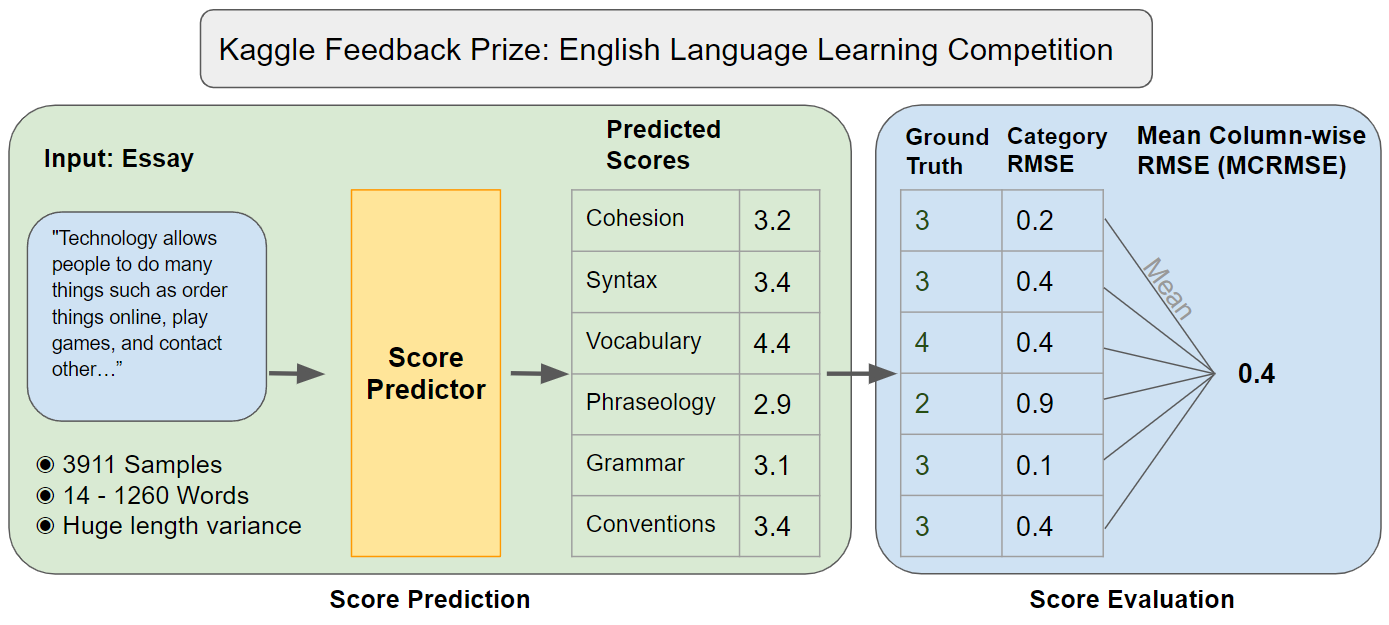

# Library Importations and Environment Definition

Let's start by loading the required packages for this project and indicating which environment we want to work in.

In [ ]:
# Library importation

!pip install transformers sentencepiece protobuf tqdm --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

import torch
import torch.optim as optim 
from torch import nn
from torch.utils.data import Dataset, DataLoader
import gc
import transformers
from transformers import AutoModel, AutoTokenizer

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Working on: ", device)

In [ ]:
ENV = "Colab" # Define your environnement whether it is "Colab", "Local", "Kaggle"

if ENV == "Colab":
    from google.colab import drive
    drive.mount("/content/drive", force_remount=True) 

    folder_path = "/content/drive/MyDrive/MIE1517 Big Brain Deep Learning" 
    dataset = pd.read_csv(folder_path+"/kaggle_dataset/train.csv")
    output_path = folder_path + "/output/"

elif ENV == "Local":
    folder_path = 'Dataset/train.csv'
    dataset = pd.read_csv(folder_path)
    output_path = "output/"

elif ENV == "Kaggle":
    folder_path = ""
    dataset = pd.read_csv("/kaggle/input/feedback-prize-english-language-learning/train.csv")
    output_path = ""

else:
    raise ValueError("Undefined environment. Please set ENV to 'Colab', 'Local', or 'Kaggle'")

# Data Exploration


Let's dive into our dataset! 

We use data from the Kaggle Dataset "Feedback Prize - English Language Learning": https://www.kaggle.com/competitions/feedback-prize-english-language-learning.

The dataset contains roughly 4000 essays scored on the six analytical measures: cohesion, syntax, vocabulary, phraseology, grammar and conventions.

As we can see below, for each sample, identified by a unique *text_id*, we have the full essay stored in the column *full_text*, as well as the associated score for each of the six analytic measures.

In [ ]:
print("Number of essays in the dataset: ", dataset.shape[0])

Number of essays in the dataset:  3911


In [ ]:
# First rows of the dataset
dataset.head(3)

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5


#### Grade repartition

As illustrated below, the grades seem to follow a bell curve centered around 3, i.e there are few samples with extreme grades.

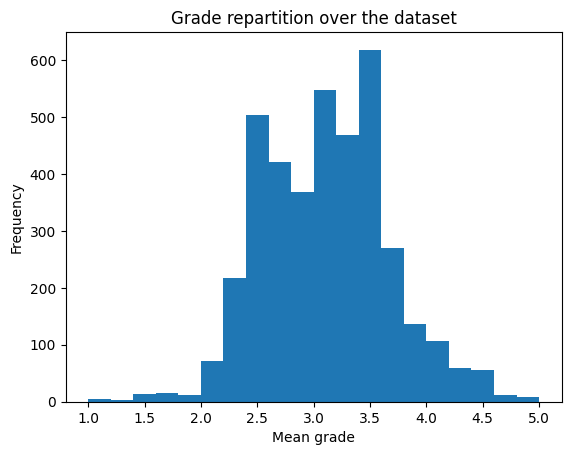

In [ ]:
mean_grade = dataset.iloc[:,2:8].mean(axis=1)

mean_grade.plot.hist(bins=20)

plt.title("Grade repartition over the dataset")
plt.xlabel("Mean grade")
plt.show()

#### Length of the essays

As illustrated below, the length of the essays varies significantly: from 14 words for the shortest to 1260 words for the longest.

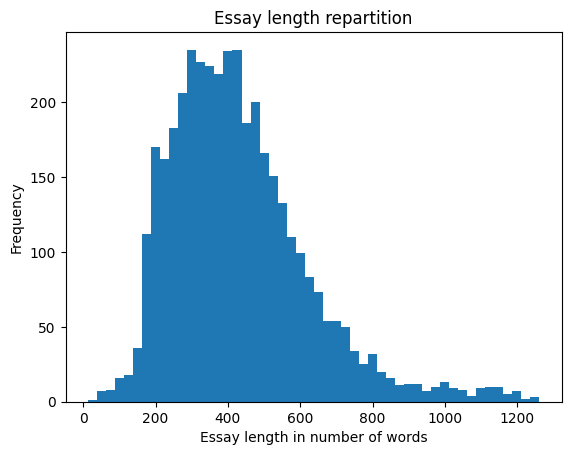

In [ ]:
# compute the number of words in each essay
num_words = dataset["full_text"].str.split().apply(len)

num_words.plot.hist(bins=50)
plt.title("Essay length repartition")
plt.xlabel("Essay length in number of words")
plt.show()

# Loss definition

We are going to use the mean columnwise root mean squared error, as required by the competition guidelines. This loss function places an equal weighting over the 6 scoring categories.

$$ \textrm{MCRMSE} = \frac{1}{N_{t}}\sum_{j=1}^{N_{t}}\sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_{ij} - \hat{y}_{ij})^2}$$

i.e. in our case:

$$\textrm{MCRMSE} = \frac{1}{6} \times (RMSE_{cohesion} + RMSE_{syntax} + RMSE_{vocabulary} + RMSE_{phraseology} + RMSE_{grammar} + RMSE_{conventions})$$


In [ ]:
def MCRMSE_torch(y_pred, y_target):
    """
    This function computes the mean columnwise root mean squared error
    Here y_target and y_pred must be torch tensors
    """
    return torch.mean(torch.sqrt(torch.mean((y_target - y_pred)**2, dim=0)))

# Main pipeline

Our pipeline includes several key components such as data augmentation, preprocessing, feature embedding, MLP regression model, and a loss function for training and validation.

We begin with data augmentation, where we explored techniques such as random synonym word replacement and Chat GPT Prompt engineering to increase the size of our dataset, however found that those methods did not increase the performance of the model. Next, we move on to preprocessing where we split long essays according to different text length control methods and rebalance and tokenize them as needed.

Our feature embedding step involves using pre-trained Transformer based neural language models to extract the necessary features from the essays. These features are then fed into our custom regression model, which consists of two layers with batch normalization and dropout to ensure accuracy. Finally, we use the MCRMSE as our loss function for backpropagation during training and validation.

With this end-to-end neural network pipeline, we aim to provide a straightforward, efficient and accurate solution for grading essays across multiple criteria, incorporating multiple techniques in data augmentation, preprocessing, and feature embedding to achieve this goal.

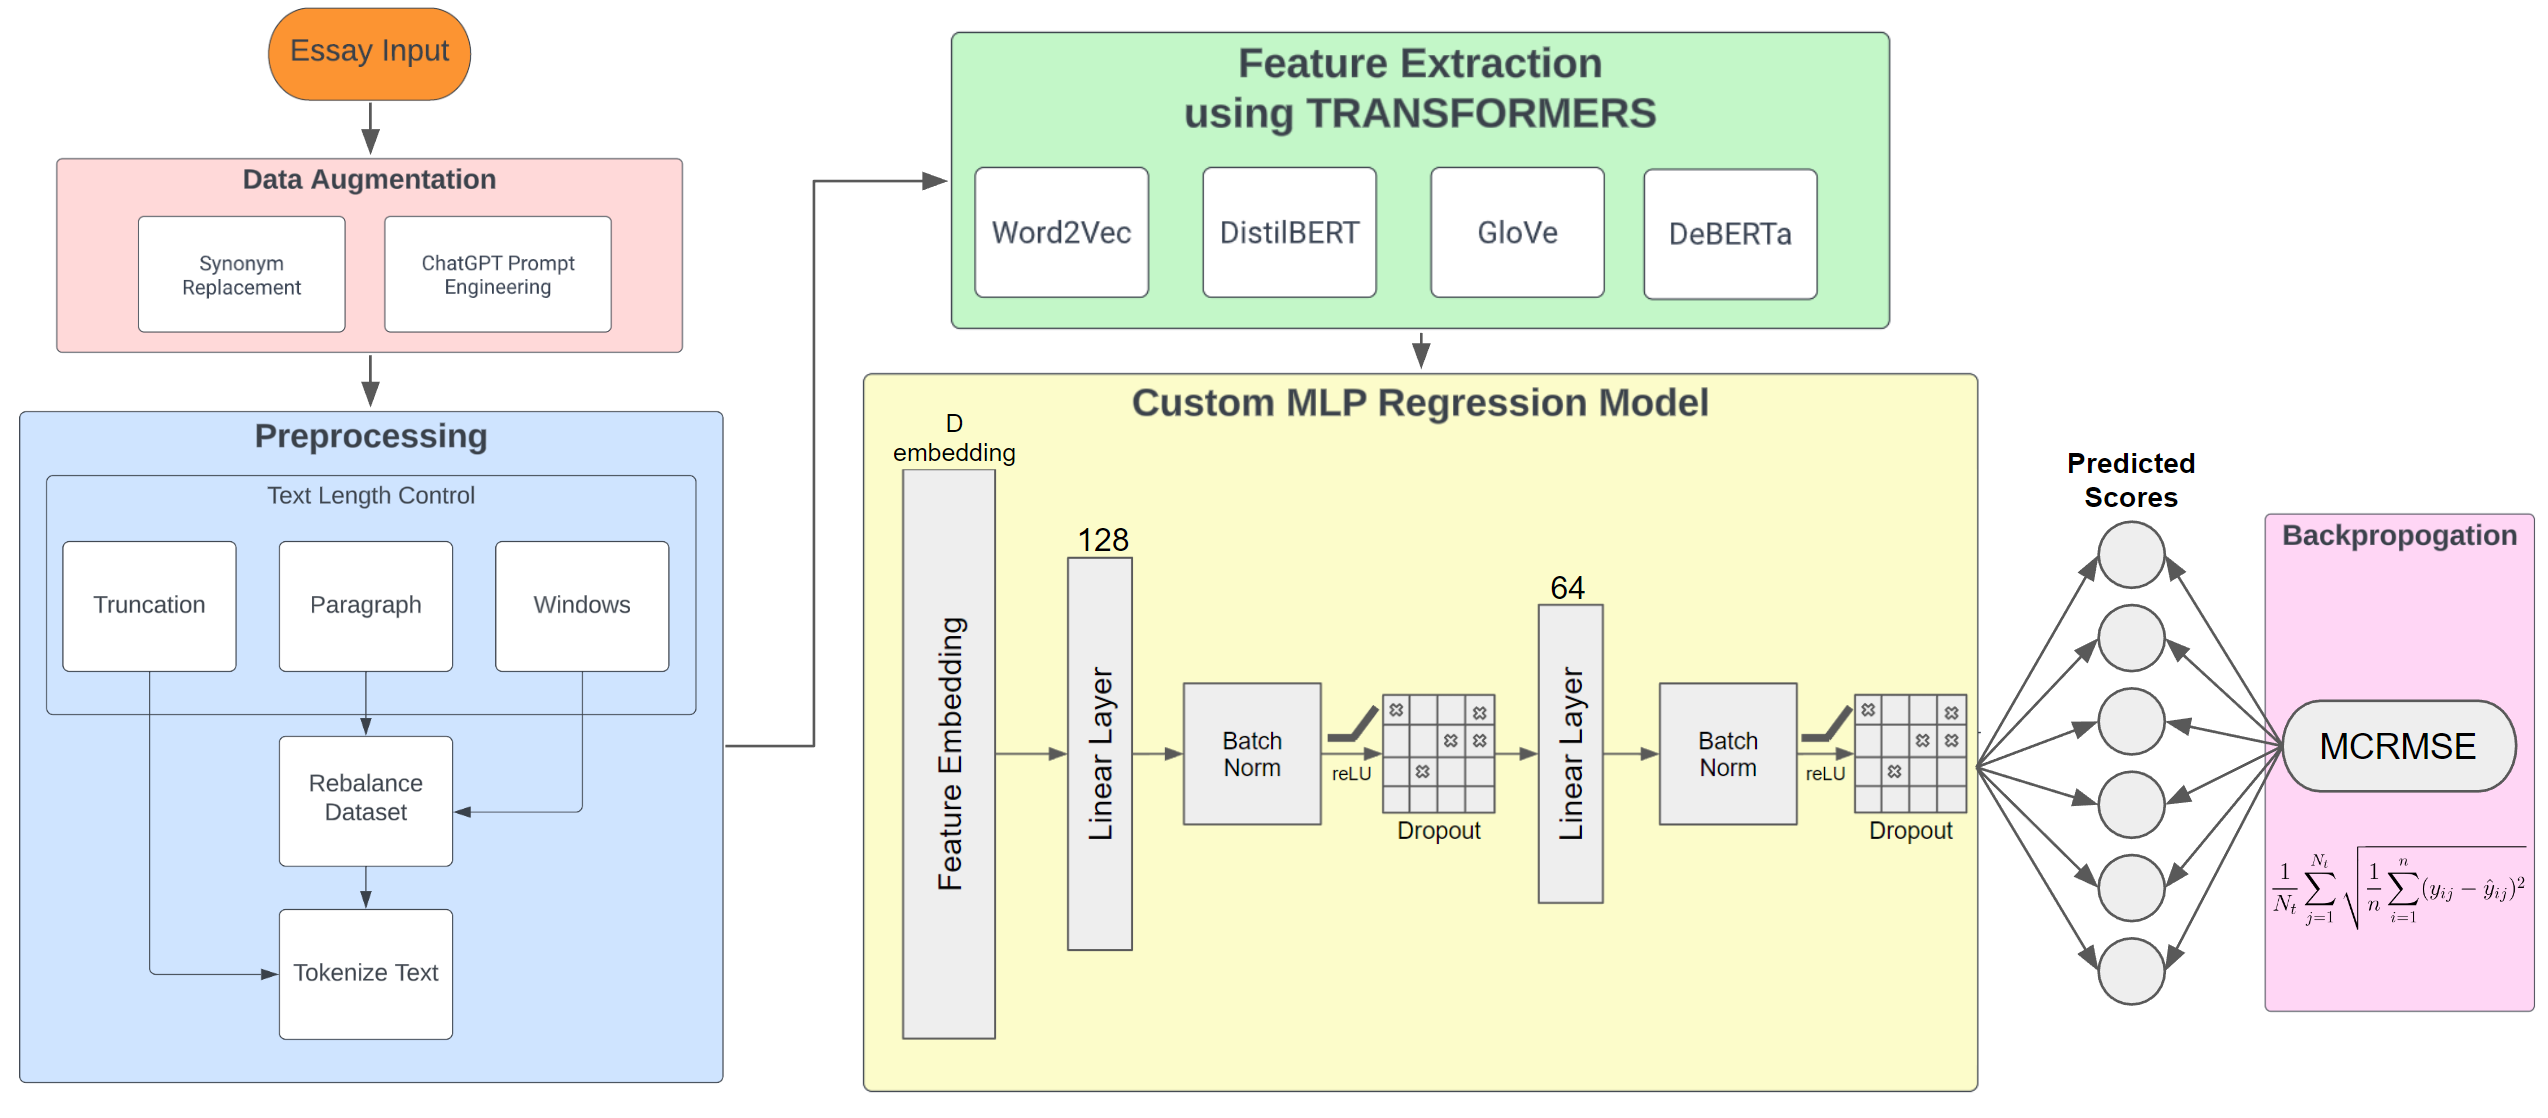


### Definition of global variables selecting model architecture

The following values chosen for `TRUNCATION_METHOD`, `MODEL`, `MODEL_NAME`, and `POOLING_METHOD`, will decide the feature extraction later in this code.

In [ ]:
MAX_LEN = 512 # Maximum sequence length input of the model
D_EMB = 768 # Output dimension of the feature extraction 

# Choose your method between "truncation" / "window" / "paragraph" to deal with essay of +500 words
TRUNCATION_METHOD = "truncation"

# Choose your pre-trained model
MODEL = 'microsoft/deberta-v3-base' # 'distilbert-base-cased'
MODEL_NAME = "Deberta" #"Bert"

# Chosse your pooling method
POOLING_METHOD = "mean_pool" # "cls_pool" / "mean_pool" / "max_pool"

MODEL_SAVING_NAME = TRUNCATION_METHOD + "_" + MODEL_NAME + "_" + POOLING_METHOD # name for saving

if ENV != "Kaggle":
    tokenizer = AutoTokenizer.from_pretrained(MODEL)
    pretrained_FE = AutoModel.from_pretrained(MODEL)
else:
    tokenizer = AutoTokenizer.from_pretrained('/kaggle/input/microsoftdeberta-v3-base/deberta_tokenizer') # local file
    pretrained_FE = AutoModel.from_pretrained('/kaggle/input/microsoftdeberta-v3-base/deberta_model') # local file

# Let's freeze the weights:
for param in pretrained_FE.parameters():
    param.requires_grad = False

## Data splitting - Train / Validation / Test

In the following code, we are splitting the dataset into a split of 70% for training, 15% for validation, and 15% for testing.

In [ ]:
#Train/Val/Test split:

TRAIN_FRAC = 0.7
VAL_FRAC = 0.15

train_df, val_df, test_df  = np.split(dataset.sample(frac=1,random_state = 42),[int(TRAIN_FRAC * len(dataset)),int((TRAIN_FRAC+VAL_FRAC) * len(dataset))])
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("FULL Dataset: {}".format(dataset.shape))
print("TRAIN Dataset: {}".format(train_df.shape))
print("VAL Dataset: {}".format(val_df.shape))
print("TEST Dataset: {}".format(test_df.shape))

FULL Dataset: (3911, 8)
TRAIN Dataset: (2737, 8)
VAL Dataset: (587, 8)
TEST Dataset: (587, 8)


## Data Processing

One of the most interesting aspects of this project is that it provides an opportunity to study a setting where the input text length is too long to be a direct model input, which is a general problem in the application of language models.


BERT, which was the state of the art model in 2018, can only take in 512 words and has 110 million network parameters. In contrast, GPT-4 which was released a few weeks ago, can take in an input that is 16 times longer, but has 1 trillion weights, which makes it 10,000x bigger than BERT. 

The reason for needing such huge networks is that the number of possible input sequences grows exponentially with input length, so scaling up networks may not be a feasible way to handle very long inputs such as entire books or websites. 




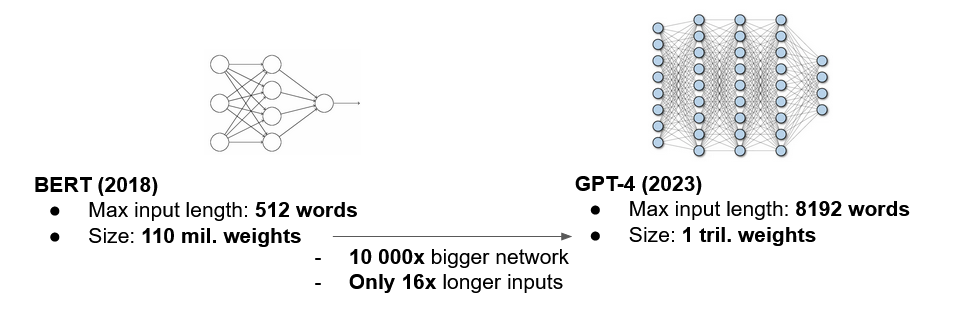

We thus explore three approaches for reducing input length while still aiming for good performance.


*   In the truncation approach, any words that are beyond the maximum allowable input length are simply discarded. Of course, the disadvantage of this approach is the loss of information after the cutoff.
*  In the paragraph splitting approach, we split each essay into its paragraphs, and define each paragraph as a new essay sample in which the scores are identical to the scores of the initial essay.  
*  Finally, in the third approach, we split essays based on sliding windows instead of paragraphs.

The last two approaches make the assumption that scores should be the same for each sub-span of the essay. 


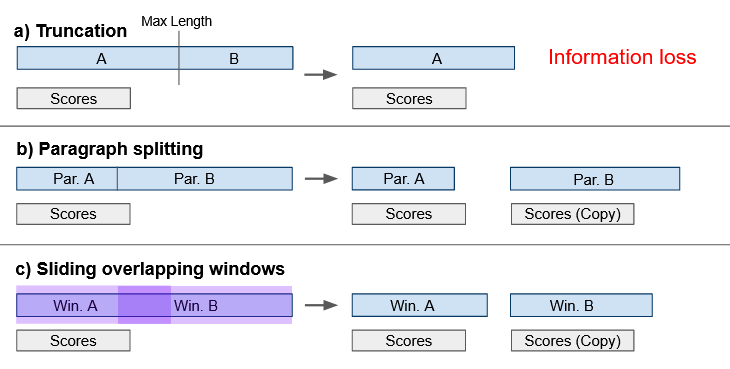

While the paragraph and window splitting approaches don’t lose information, they lead to fewer samples for shorter essays. For example, as illustrated below, an essay with only one paragraph would create 1 new sample, while a 10 paragraph essay would create 10 new samples. To rebalance the dataset, we oversampled short essays by creating copies of the resulting samples until all essays produced the same number of samples. However, this oversampling also increased the risk of overfitting for short essays.


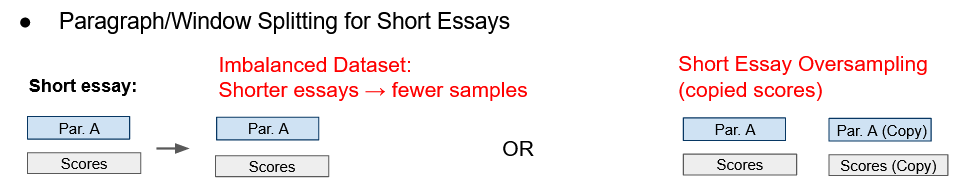

In [ ]:
class SuperProcessor:
    def __init__(self, max_length=512, window_size=512, stride=256, model_type="default", minimum_word_paragraph=5, method='truncation'):
        self.max_length = max_length
        self.window_size = window_size
        self.stride = stride
        self.model_type = model_type
        self.minimum_word_paragraph = minimum_word_paragraph
        self.method = method

    def preprocess(self, dataset, method="truncation"):
        
        # Create a copy of the input dataset
        dataset = dataset.copy()

        
        if self.model_type == "bert":
            # Add specific preprocessing steps for BERT here
            pass
        
        if method == "truncation":
            preprocessed_dataset = self.truncate_dataset(dataset)
        elif method == "window":
            preprocessed_dataset = self.window_dataset(dataset)
        elif method == "paragraph":
            preprocessed_dataset = self.paragraph_dataset(dataset)
        else:
            raise ValueError("Invalid preprocessing method. Supported methods are 'truncation', 'window', and 'paragraph'.")

        # Call the duplicate_rows() method
        preprocessed_dataset = self.duplicate_rows(preprocessed_dataset)
        
        # Convert the columns 'cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', and 'conventions' to float64
        preprocessed_dataset = self.convert_to_float(preprocessed_dataset)
        
        return preprocessed_dataset
        

    def truncate_dataset(self, dataset):
       # Apply the 'truncate_text' method to each row in the 'full_text' column of the input dataset
        dataset['processed_text'] = dataset['full_text'].apply(lambda x: self.truncate_text(x))
        return dataset

    def window_dataset(self, dataset):
        preprocessed_dataset = pd.DataFrame(columns=dataset.columns)
        if "processed_text" not in preprocessed_dataset.columns:
            preprocessed_dataset.insert(1, "processed_text", "")
        total_rows = 0
        
        for idx, row in dataset.iterrows():
            windows = self.window_approach(row['full_text'])
            for window in windows:
                preprocessed_dataset.loc[total_rows] = row
                preprocessed_dataset.loc[total_rows, "processed_text"] = window
                total_rows += 1
        
        return preprocessed_dataset

    def truncate_text(self, text):
        # Split the input text into individual words
        words = text.split()
        # Truncate the list of words to the specified maximum length
        truncated_words = words[:self.max_length]
        return ' '.join(truncated_words)

    def window_approach(self, text):
        words = text.split()
        # Create a list of windows, where each window is a subset of words of size 'self.window_size' with a stride of 'self.stride'
        windows = [words[i:i + self.window_size] for i in range(0, len(words) - self.window_size + 1, self.stride)]
        # Convert each window from a list of words to a single string
        windows_str = [' '.join(window) for window in windows]
        return windows_str
    
    
    def paragraph_dataset(self, dataset):
        preprocessed_dataset = pd.DataFrame(columns=dataset.columns)
        if "processed_text" not in preprocessed_dataset.columns:
            preprocessed_dataset.insert(1, "processed_text", "")
        total_rows = 0

        for idx, row in dataset.iterrows():
            paragraphs = self.split_by_paragraph(row['full_text'])
            for paragraph in paragraphs:
                preprocessed_dataset.loc[total_rows] = row
                preprocessed_dataset.loc[total_rows, "processed_text"] = paragraph
                total_rows += 1

        #preprocessed_dataset["targets"] = preprocessed_dataset["targets"].astype('float64') # Convert the targets column to float64
        return preprocessed_dataset

    def split_by_paragraph(self, text):
        paragraphs = text.split('\n')
        valid_paragraphs = []
        buffer = []

        for p in paragraphs:
            words = p.split()
            if len(words) >= self.minimum_word_paragraph:
                if buffer:
                    valid_paragraphs.append(' '.join(buffer))
                    buffer = []
                valid_paragraphs.append(p)
            else:
                buffer.extend(words)

        if buffer:
            valid_paragraphs.append(' '.join(buffer))

        return valid_paragraphs
    
    def duplicate_rows(self, dataset):
        # Get the maximum count of occurrences for any single text_id in the dataset
        max_count = dataset['text_id'].value_counts().max()

        # Get the text_ids that occur less than the maximum count
        ids_to_duplicate = dataset['text_id'].value_counts()[dataset['text_id'].value_counts() < max_count].index

        # Make a copy of the original dataset
        duplicated_dataset = dataset.copy()

        # Iterate over each text_id that needs to be duplicated
        for id_to_duplicate in ids_to_duplicate:
            # Get the rows in the dataset with the current text_id
            rows_to_duplicate = dataset[dataset['text_id'] == id_to_duplicate]

            # Determine the number of duplicates needed for the current text_id
            n_duplicates = max_count - len(rows_to_duplicate)

            # Sample n_duplicates number of rows with replacement from the current text_id's rows
            duplicated_rows = rows_to_duplicate.sample(n=n_duplicates, replace=True).to_dict('records')

            # Convert the duplicated rows into a DataFrame
            duplicated_rows_df = pd.DataFrame(duplicated_rows)

            # Get the index of the last occurrence of the current text_id in the duplicated dataset
            idx = duplicated_dataset[duplicated_dataset['text_id'] == id_to_duplicate].index[-1]

            # Concatenate the duplicated rows with the existing dataset, starting from the last occurrence of the current text_id
            duplicated_dataset = pd.concat([duplicated_dataset.iloc[:idx + 1], duplicated_rows_df, duplicated_dataset.iloc[idx + 1:]], ignore_index=True)

        # Return the duplicated dataset
        return duplicated_dataset
    
    

    def convert_to_float(self, dataset):
        # Convert the columns 'cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', and 'conventions' to float64
        try:
          dataset[['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']] = dataset[['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']].astype(float)
        except KeyError:
          #If the dataset doesn't contain label (prediction on test dataset)
          pass
        return dataset




In [ ]:
# Define the parameter values in a dictionary
params = {
    "max_length": MAX_LEN,
    "window_size": 512,
    "stride": 512,
    "model_type": MODEL_NAME,
    "minimum_word_paragraph": 50,
    "method": TRUNCATION_METHOD
}
# Initialize the class using the unpacked dictionary
preprocessor = SuperProcessor(**params)

# Call the preprocess method for dataset
train_df_process = preprocessor.preprocess(train_df, method=TRUNCATION_METHOD)
val_df_process = preprocessor.preprocess(val_df, method=TRUNCATION_METHOD)
test_df_process = preprocessor.preprocess(test_df, method=TRUNCATION_METHOD)

In [ ]:
train_df_process.head(3)

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,processed_text
0,772D27D400BB,It god to have a possitive attitude when you d...,3.0,2.5,2.5,2.0,2.0,2.0,It god to have a possitive attitude when you d...
1,9E8F3C6405CA,Why do people ask more then one person for adv...,3.0,2.0,3.0,3.5,3.0,3.0,Why do people ask more then one person for adv...
2,948771F795EB,"We accomplish more when we are active, and are...",4.0,4.0,3.0,4.0,4.0,4.0,"We accomplish more when we are active, and are..."


## Feature extraction

This section sets up the dataset and dataloader objects using features extracted via pretrained language model. 

### Dataset creation & tokenization

The following block of code is used to implement tokenization. It takes in a dataframe, a tokenizer, and a max length as input and preprocesses the text in the dataframe by tokenizing it using the specified tokenizer and padding/truncating it to the specified max length.

In [ ]:
# define a customed dataset that implements tokenization

class EssayDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len, unlabeled = False):
        self.len = len(dataframe)
        self.data = dataframe
        self.targets = dataframe[["cohesion", "syntax", "vocabulary", "phraseology", "grammar", "conventions"]] if not unlabeled else None
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.labeled = not(unlabeled)
        
    def __getitem__(self, index):
        text = str(self.data.processed_text[index])
        text = " ".join(text.split())
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.targets.iloc[index]) if self.labeled else 0
        } 
    
    def __len__(self):
        return self.len

In [ ]:
train_set = EssayDataset(train_df_process, tokenizer, MAX_LEN)
val_set = EssayDataset(val_df_process, tokenizer, MAX_LEN)
test_set = EssayDataset(test_df_process, tokenizer, MAX_LEN)

### Feature extraction with pretrained transformers

The following block of code defines two pooling functions (MeanPooling and MaxPooling) that take the last hidden state of a transformer model and apply a pooling operation to obtain one embedding vector representing the essay. These embedding vectors can be used as inputs to downstream tasks.

In [ ]:
def MeanPooling(last_hidden_state, attention_mask):
    """
    Calculates the mean of the non-padding embeddings in the last hidden state of the transformer model.

    Args:
        last_hidden_state (torch.Tensor): Output of the last layer of the model of shape `(batch_size, sequence_length, hidden_size)`
        attention_mask (torch.Tensor): Binary tensor of shape `(batch_size, sequence_length)` where 0 represents a padding token and 1 represents a non-padding token.

    Returns:
        torch.Tensor: Mean embeddings of shape `(batch_size, hidden_size)` after masking out the padding tokens.

    """
    # Expand attention mask to match the size of last hidden state
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()

    # Mask out padding tokens and calculate the sum of embeddings
    sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)

     # Calculate the sum of non-padding tokens in each instance and apply a lower bound of 1e-9 to avoid division by zero errors
    sum_mask = input_mask_expanded.sum(1)
    sum_mask = torch.clamp(sum_mask, min = 1e-9)

    # Compute the mean of non-padding embeddings
    mean_embeddings = sum_embeddings/sum_mask

    return mean_embeddings

def MaxPooling(last_hidden_state, attention_mask):
    """
    Calculates the max of the non-padding embeddings in the last hidden state of the transformer model.

    Args:
        last_hidden_state (torch.Tensor): Output of the last layer of the model of shape `(batch_size, sequence_length, hidden_size)`
        attention_mask (torch.Tensor): Binary tensor of shape `(batch_size, sequence_length)` where 0 represents a padding token and 1 represents a non-padding token.

    Returns:
        torch.Tensor: Max embeddings of shape `(batch_size, hidden_size)` after masking out the padding tokens.

    """
    # Expand attention mask to match the size of last hidden state
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()

    # Mask out non-padding tokens to set padding tokens to -1e4 to be sure there are not selected by the max operation
    embeddings = last_hidden_state.clone()
    embeddings[input_mask_expanded == 0] = -1e4

    # Compute the max of non-padding embeddings
    max_embeddings, _ = torch.max(embeddings, dim = 1)

    return max_embeddings

This block defines a custom dataset class that takes a preprocessed dataset, a pretrained feature extractor, and a pooling method. It extracts the features of the preprocessed dataset using the specified feature extractor and pooling method, and returns the embedding vectors as input for a downstream model.

In [ ]:
class EssayDataset_withFE(Dataset):
    def __init__(self, dataset, pretrained_FE, pooling_method, unlabeled = False):
        self.original_dataset = dataset
        self.targets = torch.tensor(dataset.targets.values) if not unlabeled else None
        self.data_embedded = self.extract_feature(pretrained_FE, pooling_method) 
        self.labeled = not(unlabeled)

    def __getitem__(self, index):
        return {"input": self.data_embedded[index], "targets": self.targets[index] if self.labeled else 0}

    def __len__(self):
        return len(self.original_dataset)

    def extract_feature(self, pretrained_FE, pooling_method):
        
        model = pretrained_FE.to(device)

        # Define a data loader
        data_loader = DataLoader(self.original_dataset, shuffle=False, batch_size=4) #we need batch to use parallelism computing

        # Create a list to hold the summary vectors
        summary_vectors = []
        
        with torch.no_grad():
            # Iterate over the data loader
            for batch in tqdm(data_loader, desc='Extracting features'): #tdqm is a package to visualize easily the avancement
                # Get the input IDs, attention mask, and targets from the batch
                input_ids = batch['ids'].to(device, dtype=torch.long)
                attention_mask = batch['mask'].to(device, dtype=torch.long)

                # Pass the input through the model to get the hidden states
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)

                # Extract the last hidden states from the output
                last_hidden_state = outputs.last_hidden_state

                # Determine the pooling method and perform pooling

                if pooling_method == "cls_pool":
                    # Use the first token's hidden state (ie. CLS) as a summary representation
                    pooled_output = last_hidden_state[:, 0, :]
                elif pooling_method == "mean_pool":
                    pooled_output = MeanPooling(last_hidden_state, attention_mask)
                elif pooling_method == "max_pool":
                    pooled_output = MaxPooling(last_hidden_state, attention_mask)
                else:
                    raise ValueError("Undefined pooling_method. Choose one of: 'cls_pool', 'mean_pool', 'max_pool'")

                # Append the summary vectors to the list
                summary_vectors.append(pooled_output.cpu())

                # Try to free some memory
                torch.cuda.empty_cache()

        # Stack the summary vectors into a single tensor
        summary_vectors = torch.cat(summary_vectors, dim=0)

        model.to('cpu')

        return summary_vectors

This code extracts features from the preprocessed datasets using the specified feature extractor and pooling method, saves them to a file, and loads them again

In [ ]:
update_text_embeddings = False 

model = pretrained_FE
pooling_method = POOLING_METHOD

dataset_name = MODEL_SAVING_NAME 

if update_text_embeddings or ENV == "Kaggle":

    t1=time.time()

    print("\nStarting Text Embedding\n")

    # Train set
    train_set_withFE = EssayDataset_withFE(train_set, model, pooling_method)
    print(f"Train set done in : {round((time.time()-t1)/60,2)} min\n") 

    t2=time.time()

    # Validation set
    val_set_withFE = EssayDataset_withFE(val_set, model, pooling_method)
    print(f"Validation set done in : {round((time.time()-t2)/60,2)} min\n") 

    t3=time.time()

    # Test set
    test_set_withFE = EssayDataset_withFE(test_set, model, pooling_method)
    print(f"Test set done in : {round((time.time()-t3)/60,2)} min\n") 
    
    # Save the transformed dataset to a file
    torch.save(train_set_withFE, output_path +'train_set_withFE_' + dataset_name + '.pth')
    torch.save(val_set_withFE, output_path +'val_set_withFE_' + dataset_name + '.pth')
    torch.save(test_set_withFE, output_path +'test_set_withFE_' + dataset_name + '.pth')

    t2=time.time()
    print(f"Total time Embedding : {round((t2-t1)/60,2)} min\n")
    
    
# Load the transformed dataset from the file
try:
    train_set_withFE = torch.load(output_path + 'train_set_withFE_' + dataset_name + '.pth')
    val_set_withFE = torch.load(output_path +'val_set_withFE_' + dataset_name + '.pth')
    test_set_withFE = torch.load(output_path +'test_set_withFE_' + dataset_name + '.pth')
    print("Text Embedding loaded")

except FileNotFoundError:
    raise FileNotFoundError("The files with the extracted features do not exist. Please update the embeddings by setting update_text_embeddings = True.")

Text Embedding loaded


### Data loader definition

The following code sets the batch size, shuffling and other parameters for training, validation and testing data loaders. Then it creates the data loaders for the preprocessed datasets with the specified parameters.

In [ ]:
TRAIN_BATCH_SIZE = 32 if ENV !="Kaggle" else 128
VALID_BATCH_SIZE = 32

train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0,
                'drop_last': True  # ANTON: drop_last = True avoids a batch with only one sample which causes an error
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0,
                'drop_last': True # ANTON: drop_last = True avoids a batch with only one sample which causes an error
                } 

training_loader = DataLoader(train_set_withFE, **train_params)
validation_loader = DataLoader(val_set_withFE, **test_params)
testing_loader = DataLoader(test_set_withFE, **test_params)

## Dense Model

The provided code defines a flexible and dynamic Multilayer Perceptron (MLP) model to be used as the dense regression layers after features are extracted using language model. The ModelConfig class allows users to configure various aspects of the MLP, such as the number of layers, hidden layer sizes, dropout rates, learning rate, and epochs.

The MLP class then takes the configuration object as input and constructs a neural network based on the given parameters. The network consists of fully connected layers, batch normalization, ReLU activation functions, and dropout layers, providing users with the ability to customize the model's architecture and behavior. 

The output layer applies a sigmoid activation function, followed by a transformation to constrain the output range between 1 and 5. This dynamic design enables us to experiment with different MLP configurations.

In [ ]:
class ModelConfig:
    def __init__(self, name, D_emb, num_layers, hidden_sizes, dropout_rates, learning_rate=None, epochs=None):
        self.name = name
        self.D_emb = D_emb
        self.num_layers = num_layers
        self.hidden_sizes = hidden_sizes
        self.dropout_rates = dropout_rates
        self.learning_rate = learning_rate
        self.epochs = epochs


In [ ]:
class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()

        layers = []
        input_size = config.D_emb
        for i in range(config.num_layers):
            layers.append(nn.Linear(input_size, config.hidden_sizes[i]))
            layers.append(nn.BatchNorm1d(config.hidden_sizes[i]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(config.dropout_rates[i]))
            input_size = config.hidden_sizes[i]

        layers.append(nn.Linear(config.hidden_sizes[-1], 6))
        layers.append(nn.BatchNorm1d(6))
        layers.append(nn.Sigmoid())

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.model(x)
        # After final activation, affine transformation of the output of sigmoid layer to constrain output from 1 to 5
        x = x*4 + 1
        return x


### Utility functions

The following code are utility functions. **plot_training_curve** is used to plot the training and validation loss of the model. **get_model_name** returns a model name string based on provided model configuration parameter. **load_model** loads a previously saved MLP model at a specified epoch, and **evaluate** and **prediction** are used to evaluate the performance of the model on validation and test sets. 

In [ ]:
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    n = len(train_loss) # number of epochs
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.grid()
    plt.show()

def RMSE_numpy(y_pred, y_target):
    """
    This function computes the root mean squared error
    Here y_target and y_pred must be torch numpy array
    """
    n, Nt = y_target.shape

    return np.sqrt(1/n*((y_target-y_pred)**2).sum(axis=0))

def get_model_name(name, config, epoch = None):
    path = "model_{0}_layers{1}_lr{2}_hs{3}_dr{4}".format(name,
                                                             config.num_layers,
                                                             config.learning_rate,
                                                             '_'.join(map(str, config.hidden_sizes)),
                                                             '_'.join(map(str, config.dropout_rates)))
    if epoch != None:
        path = path + f"_epoch{epoch}"
    return path
    
def load_model(model_name, num_epochs, name = MODEL_SAVING_NAME, d_emb = D_EMB):
    """
    Loads a saved MLP model with the given model name at a specific epoch.
    """

    def parse_model_name(model_name, name = name, d_emb = d_emb):
        """
        Parses the model name string and returns a dictionary with the model name, number of layers, embedding dimension,
        hidden layer sizes, and dropout rates.
        """

        parts = model_name.split('_')
        num_layers = int(parts[5][6:])
        
        hs, dr = model_name.split('hs')[1].split('dr')
        hidden_sizes = list(map(int, hs.split('_')[:-1]))
        dropout_rates = list(map(float, dr.split('_')))

        return {"name": name, "num_layers": num_layers, "D_emb": d_emb, "hidden_sizes": hidden_sizes, "dropout_rates": dropout_rates}

    # Define model
    param_model = parse_model_name(model_name)
    config = ModelConfig(**param_model)
    model = MLP(config) 

    # Load state
    model_name = model_name+f'_epoch{num_epochs}'
    state = torch.load(output_path + model_name + ".pt", map_location=torch.device('cpu'))
    model.load_state_dict(state)

    return model
    
def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.
     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         loss: A scalar for the average loss function over the validation set
     """
    net.eval()
    net.to(device)
    total_loss = 0.0
    total_epoch = 0
    with torch.no_grad():
        for i, data in enumerate(loader, 0):
        # Get the inputs
            inputs = data['input'].to(device)
            targets = data['targets'].to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            total_epoch += len(targets)
        loss = float(total_loss) / (i + 1)
    return loss

def prediction(net, loader, labeled=True):
    """ Return the prediction and the targets on a given set.
     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the set
     """
    net.eval()
    net.to(device)
    
    preds_list = []
    targets_list = []

    with torch.no_grad():
        for i, data in enumerate(loader):
        # Get the inputs
            inputs = data['input'].to(device)
            outputs = net(inputs)
            preds_list.extend(outputs.cpu().tolist())

            if labeled:
                targets = data['targets'].to(device)
                targets_list.extend(targets.cpu().tolist())

    return np.array(preds_list), np.array(targets_list)

### Training function

The following code is used to train the model. **train_net** trains the neural network using a specified configuration and data loaders.

In [ ]:
def train_net(net, config, train_loader, val_loader):

    # Define the Loss function and optimizer
    criterion = MCRMSE_torch
    optimizer = optim.SGD(net.parameters(), lr=config.learning_rate, momentum=0.9)

    # Set up some numpy arrays to store the training/test loss
    train_loss = np.zeros(config.epochs)
    val_loss = np.zeros(config.epochs)

    # Train the network
    start_time = time.time()
    net = net.to(device)
   
    #############################################
    for epoch in range(config.epochs):  # loop over the dataset multiple times
        net.train()
        total_train_loss = 0.0
        total_epoch = 0
        
        for i, data in enumerate(train_loader):
            # Get the inputs
            inputs = data['input'].to(device)
            targets = data['targets'].to(device)
    
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            # Calculate the statistics
            total_train_loss += loss.item()
            total_epoch += len(targets)
            
            # Try to free some memory
            del inputs
            del targets
            gc.collect()
            torch.cuda.empty_cache()
            
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_loss[epoch] = evaluate(net, val_loader, criterion)

        if epoch % 5 == 0 or epoch == config.epochs-1:
            print(("Epoch {}/{}: Training loss: {:.3f} | "+
                   "Validation loss: {:.3f}").format(
                       epoch + 1,
                       config.epochs,
                       train_loss[epoch],
                       val_loss[epoch]))
        
        # Save the current model (checkpoint) to a file
        model_name = get_model_name(config.name, config, epoch)
       
        torch.save(net.state_dict(), output_path + model_name + '.pt')
      
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    
    model_name = get_model_name(config.name, config)
    
    # Write the train/test loss into CSV file for plotting later
    np.savetxt("{}_train_loss.csv".format(output_path + model_name), train_loss)
    np.savetxt("{}_val_loss.csv".format(output_path + model_name), val_loss)
    
    return model_name

# Model Tuning

To provide more insight into our process for identifying the best model, we conducted a multi-step hyperparameter search. Initially, we evaluated several models, including Word2Vec, GloVe, DistillBert, and DeBERTa-v3-base, using default values to determine the best performing language model. Subsequently, we repeated this process using the same approach to identify the preferred pooling method for the selected language model, with the options of "CLS" pooling, mean pooling, and max pooling. Finally, utilizing the values identified from the prior steps, we conducted a grid search hyperparameter tuning on several parameters, including the number of layers, dropout rate, and learning rate, to further optimize the model.

The first steps of model and pooling method selection require changing the global variables `MODEL` and `POOLING_METHOD` defined earlier and rerunning the code to perform feature extraction using this new model.

The last step of hyperparameter search can be done by calling the following function:


In [ ]:
import itertools

def model_search(output_path, MODEL_SAVING_NAME, training_loader, validation_loader, num_layers_options, hidden_sizes_options, dropout_rates_options, learning_rate_options):
    
    for num_layers_idx, num_layers in enumerate(num_layers_options):
        # itertools.product is used to make sure when we test, the hidden sizes matches the rest
        for hidden_sizes, dropout_rates, learning_rate in itertools.product(
            hidden_sizes_options[num_layers_idx], dropout_rates_options[num_layers_idx], learning_rate_options):

            params_hyper = {
                "name": MODEL_SAVING_NAME,
                "D_emb": 768,
                "num_layers": num_layers,
                "hidden_sizes": hidden_sizes,
                "dropout_rates": dropout_rates,
                "learning_rate": learning_rate,
                "epochs": 15
            }

            config = ModelConfig(**params_hyper)
            model = MLP(config)

            #print(f"num_layers: {num_layers}, hidden_sizes: {hidden_sizes}, dropout_rates: {dropout_rates}, learning_rate: {learning_rate}, model_path: {model_name}")
            model_name = train_net(model, config, training_loader, validation_loader)

            print(model_name) # forgot to add this

            plot_training_curve(output_path + model_name)

The following is an example of how to call the function:

In [ ]:
redo_grid_search = False

if redo_grid_search:
    num_layers_options = [2, 3, 4]
    hidden_sizes_options = [[[128,64],[64, 32], [32, 16]],
                            [[64, 32, 16], [32, 16, 8]],
                            [[128, 64, 32, 16], [64, 32, 16, 8]]]
    dropout_rates_options = [[[0.4, 0.3],[0.3,0.3]],
                            [[0.3, 0.3, 0.3],[0.2,0.2,0.2]],
                            [[0.3, 0.3, 0.2, 0.2]]]
    learning_rate_options = [0.001]

    model_search(output_path, MODEL_SAVING_NAME, training_loader, validation_loader, num_layers_options, hidden_sizes_options, dropout_rates_options, learning_rate_options)


To summarize, the following values were tested in a gridsearch manner in our case:

| Num Layers | Hidden Sizes        | Dropout Rates        | Learning Rate |
|------------|---------------------|----------------------|---------------|
| 2          | [128, 64]           | [0.4, 0.3]           | 0.001         |
| 2          | [128, 64]           | [0.3, 0.3]           | 0.001         |
| 2          | [64, 32]            | [0.4, 0.3]           | 0.001         |
| 2          | [64, 32]            | [0.3, 0.3]           | 0.001         |
| 2          | [32, 16]            | [0.4, 0.3]           | 0.001         |
| 2          | [32, 16]            | [0.3, 0.3]           | 0.001         |
| 3          | [64, 32, 16]        | [0.3, 0.3, 0.3]      | 0.001         |
| 3          | [64, 32, 16]        | [0.2, 0.2, 0.2]      | 0.001         |
| 3          | [32, 16, 8]         | [0.3, 0.3, 0.3]      | 0.001         |
| 3          | [32, 16, 8]         | [0.2, 0.2, 0.2]      | 0.001         |
| 4          | [128, 64, 32, 16]   | [0.3, 0.3, 0.2, 0.2] | 0.001         |
| 4          | [64, 32, 16, 8]     | [0.3, 0.3, 0.2, 0.2] | 0.001         |


# Quantitative Results

To evaluate quantitatively the performance of our model, let's first compute some reference losses. On one hand, our baseline model - a dummy predictor that always returns the mean grade, achieves a MCRMSE loss of 0.65 on the validation set. On the other end, we know from the Kaggle leaderboard that after 3 months of competition, the best team achieved a loss of 0.44.

We implemented different pre-trained models from standard word embeddings, such as word2vec and glove, to more complex transformer-based models, such as DistillBert and DeBERTa. 

For each model, we did a hyperparameter tuning of the following parameters:
- preprocessing method (truncation, window, paragraph)
- pooling technique
- number and size of layers in the MLP Regressor
- dropout rate
- batch normalization vs layer normalization
- learning rate
- number of epochs

The following table summarizes the best results we manage to have after hyperparameter tuning for each pre-trained model.

| Model              | Validation Loss |
| :---------------- | :------: |
| Baseline - Mean predictor       |   0.65   |
| Word2Vec          |   0.59   |
| Glove    |  0.58   |
| Bert Model |  0.50   |
| DeBERTa Model |  0.45   |  
&nbsp;  

The overall best results were achieved using the following architecture: 
- preprocessing: truncation method
- feature extraction: pre-trained transformer model DeBERTa  + mean pooling
- dense model: 2 hidden layers of size 128 and 64 with dropout rate of 0.4 and 0.3
- learning rate of 0.001 for 80 epochs.

&nbsp;  
Let's visualize the learning curves corresponding to our best model:

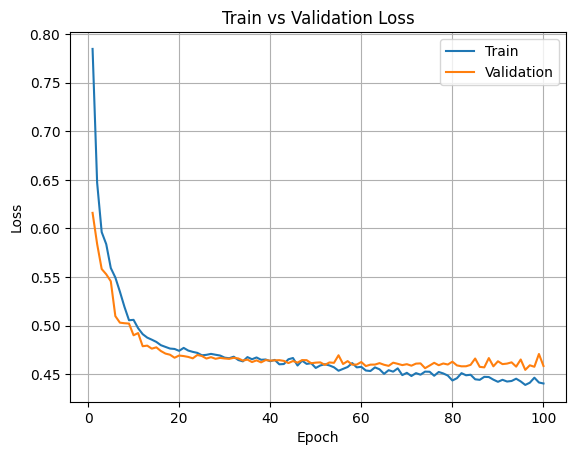

In [ ]:
retrain_best_model = False

if retrain_best_model:
    params_hyper = {
        "name": MODEL_SAVING_NAME,
        "D_emb": D_EMB,
        "num_layers": 2,
        "hidden_sizes": [128, 64],
        "dropout_rates": [0.4, 0.3],
        "learning_rate": 0.001,
        "epochs": 100
    }

    config = ModelConfig(**params_hyper)
    model = MLP(config)

    model_name = train_net(model, config, training_loader, validation_loader)
else:
    model_name = "model_truncation_Deberta_mean_pool_layers2_lr0.001_hs128_64_dr0.4_0.3"

plot_training_curve(output_path + model_name)

Once this benchmark done and our best model selected, we can test it on the Kaggle test set. Here are the final results:

| Model              | Test Loss |
| :---------------- | :------: |
| Baseline - Mean predictor     |   0.66   |
| Our DeBERTa Model          |   0.46   |
| Best result of Kaggle competition      |   0.44   |


Our model achieves a loss of 0.46 indicating the model's strong performance.

# Qualitative Results

To gain further insight, it is interesting to examine how our model performs on each category separately.

In [ ]:
best_model = load_model("model_truncation_Deberta_mean_pool_layers2_lr0.001_hs128_64_dr0.4_0.3", num_epochs = 80)

preds, targets = prediction(best_model, validation_loader)

In [ ]:
rmse_per_category = RMSE_numpy(preds, targets)

category_names = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']

rmse_dict = {category_names[i]: rmse_per_category[i] for i in range(len(category_names))}

display(pd.DataFrame([rmse_dict], columns=category_names, index=["RMSE per category"]).round(2))

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
RMSE per category,0.51,0.45,0.42,0.48,0.47,0.46


We can see that our model performs better on predicting vocabulary grades than cohesion grades. Cohesion is a complex aspect of writing that involves analyzing the relationships between different parts of the essay, such as transitions and sentence structure. Therefore, it may be more challenging for our feature extractor to accurately capture these relationships compared to simply identifying the presence of specific vocabulary words. 

To improve performance on cohesion grades, one potential approach would be to incorporate more sophisticated pooling techniques, such as hierarchical pooling or attention-based pooling, that can capture more complex relationships between different parts of the essay. Additionally, using more advanced transformer-based models may also improve performance on this task by providing more powerful language understanding capabilities.


### Grade distribution
We can also visualize the distribution of the grades and notice that the model has a slight bias towards the mean and tends not to assign very high grades.


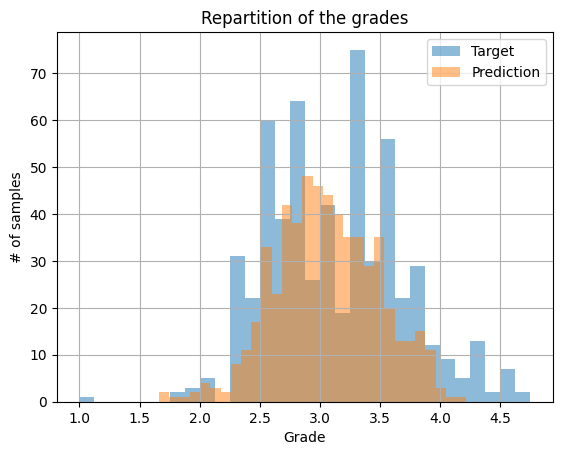

In [ ]:
mean_preds = preds.mean(axis=1)
mean_targets = targets.mean(axis=1)

result_dict = {"Target": mean_targets, "Prediction": mean_preds}
results_df = pd.DataFrame(result_dict)

# Set up the figure and axis
fig, ax = plt.subplots()

# Plot the histograms
results_df.Target.hist(bins=30, alpha=0.5, label='Target', ax=ax)
results_df.Prediction.hist(bins=30, alpha=0.5, label='Prediction', ax=ax)

# Add labels and title
ax.set_xlabel('Grade')
ax.set_ylabel('# of samples')
ax.set_title('Repartition of the grades')
ax.legend()

plt.show()

In addition, it can be interesting to see concretely how our model performs on a given essay with a very poor or very good grade.

Let's find the poorest and best essays of our dataset and see which grades our model predicts.

In [ ]:
def predict(df, tokenizer, pretrained_FE, model, truncation_method, pooling_method):

    # Call the preprocess method for dataset# Define the parameter values in a dictionary
    df_process = preprocessor.preprocess(df, method=truncation_method)
    test_set = EssayDataset(df_process, tokenizer, MAX_LEN, unlabeled = True)

    #Feature extraction
    test_set_withFE = EssayDataset_withFE(test_set, pretrained_FE, pooling_method, unlabeled = True) 

    loader = DataLoader(test_set_withFE, shuffle=False, batch_size=4)

    model.eval()
    model.to(device)
    
    preds_list = []

    with torch.no_grad():
        for i, data in enumerate(loader):
            inputs = data['input'].to(device)
            outputs = model(inputs)
            preds_list.extend(outputs.cpu().tolist())

    results = pd.DataFrame(preds_list, columns = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions'])
    results.insert(0,"text_id", df.text_id)

    return results

In [ ]:
import textwrap

mean_grade = dataset.iloc[:,2:8].mean(axis=1)

id_lowest_grade = mean_grade.idxmin()

poorest_essay_df = dataset.iloc[[id_lowest_grade]].reset_index()

print("Poorest essay\n")
print(textwrap.fill(poorest_essay_df.iloc[0].full_text,100))
print("\nTarget Grades:")
display(poorest_essay_df.iloc[[0],3:])
print("")
# Prediction
preds = predict(poorest_essay_df, tokenizer, pretrained_FE, model = best_model, truncation_method = "truncation", pooling_method = "mean_pool")

print("\nPredicted Grades:")
display(preds.drop(["text_id"], axis = 1))

Poorest essay

some student offer distance learning as an option for student to attend classes from homr by wat of
online pr video conferencing. i think student would benefit form being able to attend classesfrom
home. you are authorized take the electronic version of this you will taking this promptsome student
offer distance learning as an option for student to attend classes from homr by wat of online pr
video conferencing. some student offer distance learning as an option for student to attend classes
from homr by wat of online pr video conferencing. some student offer distance learning as an option.
online pr video conferencing. the right view the prompt and teh checklist for writers vvsome student
offer distance learning as an option for student to attend classes from homr by wat of online pr
video conferencing. some student offer distance learning as an option for student to attend classes
from homr by wat of online pr video conferencing. some student offer distance learning as 

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,1.0,1.0,1.0,1.0,1.0,1.0


Extracting features: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s]



Predicted Grades:


,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,1.536057,1.551536,1.742383,1.489784,1.674842,1.574263


In [ ]:
import textwrap

mean_grade = dataset.iloc[:,2:8].mean(axis=1)

id_highest_grade = mean_grade.idxmax()

highest_essay_df = dataset.iloc[[id_highest_grade]].reset_index()

print("Highest essay\n")
print(textwrap.fill(highest_essay_df.iloc[0].full_text,100))
print("\nTarget Grades:")
display(highest_essay_df.iloc[[0],3:])
print("")
# Prediction
preds = predict(highest_essay_df, tokenizer, pretrained_FE, model = best_model, truncation_method = "truncation", pooling_method = "mean_pool")

print("\nPredicted Grades:")
display(preds.drop(["text_id"], axis = 1))

Highest essay

I agree with Michelangelo's statement as I have found through experience that it benefits me more to
set high expectations and not reach my goal, rather than settling on a low goal and achieving it.
When setting high goals, I find that I learn more and progress my abilties further than I do with a
lower goal. This is because setting high goals requires confidence, challenges, and pride.  Firstly,
hard work is required to achieve high goals, and requires confidence. Confidence involves having
trust and believing that you are capable of accomplishing something. I have found that when I set
high goals, I feel more confident in my abilities. With lower goals however, my confidence is lower
as I settle for the easier path and do not trust myself to do better. With a higher aim, my
confidence motivates me to not give up. I tend to try harder, and always believe in myself. For
example, at school, I had to choose whether I wanted to try out for the varsity tennis team or
remain 

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,5.0,5.0,5.0,5.0,5.0,5.0


Extracting features: 100%|██████████| 1/1 [00:00<00:00, 11.45it/s]



Predicted Grades:


,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,4.290895,4.264737,4.337031,4.307042,4.296031,4.343038


Intuitively, we can see that the first example of the lowest scorring essay has a score closely predicted by the model. However, the final essay has an average of around .7 lower than the target grade. We can directly see from this the models lower spread compared to the real grade distribution.

# Demonstration on new data

In the following part, we asked Chat GPT to prompt us one bad essay and one good one to see what our model would predict. The following is the prompt we asked on GPT. 

**Prompt:** "I need to create a template essay to evaluate the language proficiency of English Language Learners in grades 8-12. PLease provide me with a short two-paragraoh essay that replicates how a student with poor language proficiency would write. The essay should reflect the student's limited knowledge of cohesion, syntax, vocabulary, phraseloogy, grammar, and conventions of the English language. I want the following example you give to return an example of a poor example a student would produce. Only provide me with the essay."

**Bad Essay Answer:** My weekend was boring. I stay at home and watch tv. I like watch reality shows. 
                                I also play video game. My favorite game is call of duty. I play for hours. 
                                I don't like read books. I have to read book for school but is hard. I not understand the words.

**Prompt:** "Can you create a similar essay for an English language laerner between the grade of 8th to 12th grade, that would demonstrate a proficient understanding of knowledge of cohesion, syntax, vocabulary, phraseloogy, grammar, and conventions of the English language? Remember to demonstrate a profeccient understanding for a new English learner in those categories which include errors in the categories that were mentionned. Please only provide me with the essay."              

**Good Essay Answer:** My weekend was boring. I stay at home and watch tv. I like watch reality shows. 
                                I also play video game. My favorite game is call of duty. I play for hours. 
                                I don't like read books. I have to read book for school but is hard. I not understand the words.

In [ ]:
new_essay1 = { "text_id": "ChatGPT - Good essay",
               "full_text": """ Last weekend, I had a lot of fun. On Saturday, I went to the park with my family and played a game of soccer. 
                                Afterwards, we had a picnic and ate sandwiches and fruit. On Sunday, I stayed home and watched a movie on Netflix. 
                                I like to watch comedies because they make me laugh. I also enjoy reading books, and I recently finished a science 
                                fiction novel about time travel. Although it was challenging at times, I found the story fascinating and thought-provoking.
                                """}

new_essay2 = { "text_id": "ChatGPT - Bad essay",
               "full_text": """ My weekend was boring. I stay at home and watch tv. I like watch reality shows. 
                                I also play video game. My favorite game is call of duty. I play for hours. 
                                I don't like read books. I have to read book for school but is hard. I not understand the words.
                                """}

essay_list = [new_essay1, new_essay2]
new_test_df = pd.DataFrame(essay_list)

preds = predict(new_test_df, tokenizer, pretrained_FE, model = best_model, truncation_method = "truncation", pooling_method = "mean_pool")

display(preds)

Extracting features: 100%|██████████| 1/1 [00:00<00:00,  6.66it/s]


,text_id,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,ChatGPT - Good essay,3.894424,3.931499,3.94972,3.981948,4.181274,4.001264
1,ChatGPT - Bad essay,2.608691,2.525342,2.73090,2.525788,2.483428,2.636936


Our model assigned a higher score to the good essay for each criterion. The criteria that were graded most similarly were vocabulary, with a difference of 1.21, while grammar had the highest difference at 1.7. Overall, our model gave the good essay an average score of 3.98, whereas the predicted score for the other essay was 2.58. This means that our model assigned an average score that was 1.4 points higher to the good essay.

Now, let's try one of Florian's highschool essay on eating habits:

" Nowadays, we can split people in two groups : the one who want to eat healthy meal - the team “bio, gluten-less, vegan” – and the one consuming junk food and prepared meal, mainly because it’s easier. In my opinion, the consumption of junk food is not going to increase much anymore. Awareness is being raised about issue such as obesity or environmental drawbacks from intensive farming.  And thus I think that the current trend of eating healthier meal will continue. The fact that they are trying to reduce their consumption of meat is consistent with tomorrow’s issues. Since we’ll be nearly 10 billion on earth by 2050, our eating habits have to change : the Earth can’t feed all these people like we are now in the European culture. The farming and processing of animal livestock – beef for example - is destroying wild nature and releasing thousands of tonnes of CO2 into the atmosphere whereas crickets, the most commonly farmed insects, have a smaller environmental footprint. 

Eligible bugs might be the solution : they are as nutritious than beef but beef require 100 times more food, 2000 times more water and release 100 more CO2 ; this is telling. In addition with growing concerns about our planet health, I believe that bugs will be very soon in every restaurant."
                            

In [ ]:
new_essay3 = { "text_id": "Florian's 12th grade essay",
               "full_text": """ Nowadays, we can split people in two groups : the one who want to eat healthy meal 
                                - the team “bio, gluten-less, vegan” – and the one consuming junk food and prepared meal, 
                                mainly because it’s easier. In my opinion, the consumption of junk food is not going to increase much anymore. 
                                Awareness is being raised about issue such as obesity or environmental drawbacks from intensive farming. 
                                And thus I think that the current trend of eating healthier meal will continue. The fact that they are trying to 
                                reduce their consumption of meat is consistent with tomorrow’s issues. Since we’ll be nearly 10 billion on earth 
                                by 2050, our eating habits have to change : the Earth can’t feed all these people like we are now in the European culture. 
                                The farming and processing of animal livestock – beef for example - is destroying wild nature and releasing thousands of 
                                tonnes of CO2 into the atmosphere whereas crickets, the most commonly farmed insects, have a smaller environmental footprint. 
                                Eligible bugs might be the solution : they are as nutritious than beef but beef require 100 times more food, 2000 times more 
                                water and release 100 more CO2 ; this is telling. In addition with growing concerns about our planet health, I believe that bugs 
                                will be very soon in every restaurant.
                                """}

essay_list = [new_essay3]
new_test_df = pd.DataFrame(essay_list)

preds = predict(new_test_df, tokenizer, pretrained_FE, model = best_model, truncation_method = "truncation", pooling_method = "mean_pool")

display(preds)

Extracting features: 100%|██████████| 1/1 [00:00<00:00, 16.19it/s]


,text_id,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,Florian's 12th grade essay,3.764701,3.687463,3.86449,3.714384,3.65049,3.732745


Let's try more original essays to see the limit of our model.

- A research paper abstract (Beland, Justin J.. “Bayesian Optimization Under Uncertainty.” (2017)): 

"We consider the problem of robust optimization, where it is sought to design a system such that it sustains a specified measure of performance under uncertainty.This problem is challenging since modeling a complex system under uncertainty can be expensive and for most real-world problems robust optimization will not be computationally viable. In this paper, we propose a Bayesian methodology to efficiently solve a class of robust optimization problems that arise in engineering design under uncertainty. The central idea is to use Gaussian process models of loss functions (or robustness metrics) together with appropriate acquisition functions to guide the search for a robust optimal solution. Numerical studies on a test problem are presented to demonstrate the efficacy of the proposed approach."

- A blank essay:

" "

In [ ]:
new_essay4 = { "text_id": "Research paper abstract",
               "full_text": """We consider the problem of robust optimization, where it is sought to design a
                                system such that it sustains a specified measure of performance under uncertainty.
                                This problem is challenging since modeling a complex system under uncertainty
                                can be expensive and for most real-world problems robust optimization will not
                                be computationally viable. In this paper, we propose a Bayesian methodology to
                                efficiently solve a class of robust optimization problems that arise in engineering
                                design under uncertainty. The central idea is to use Gaussian process models of loss
                                functions (or robustness metrics) together with appropriate acquisition functions to
                                guide the search for a robust optimal solution. Numerical studies on a test problem
                                are presented to demonstrate the efficacy of the proposed approach.
                                """}

new_essay5 = { "text_id": "Blank essay",
               "full_text": """ """}

essay_list = [new_essay4, new_essay5]
new_test_df = pd.DataFrame(essay_list)

preds = predict(new_test_df, tokenizer, pretrained_FE, model = best_model, truncation_method = "truncation", pooling_method = "mean_pool")

display(preds)

Extracting features: 100%|██████████| 1/1 [00:00<00:00,  9.40it/s]


,text_id,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,Research paper abstract,3.927367,3.776050,3.939796,3.856514,3.906927,3.732549
1,Blank essay,2.180983,1.971145,2.486327,2.134086,1.989977,1.752064


Here we can see that one of the limitations of the model as it was train on English learning students essays it has difficulties understanding and effectively grading scientific papers. We can also see that the blank essay got a low score but not the lowest one as it would deserve.

# Related work

Several papers have explored Automated Essay Scoring using transformers, though none from a multi-aspect perspective. For instance, Ormerod [Ormerod, 2021] demonstrate the efficiency of ensembles of small transformers, while Rodriguez [Rodriguez, 2019] compare off-the-shelf BERT and XLNet to traditional NLP models. The methods that we (and other competitors) explored in this competition are distinct from these works due to the need to consider multiple scoring categories.

**[Ormerod, 2021]** Ormerod, Christopher M, Akanksha Malhotra & Amir Jafari. 2021. Automated essay scoring using efficient
transformer-based language models. arXiv preprint arXiv:2102.13136 .

**[Rodriguez, 2019]** Rodriguez, Pedro Uria, Amir Jafari & Christopher M Ormerod. 2019. Language models and automated essay scor-
ing. arXiv preprint arXiv:1909.09482 .




# Discussion

Overall, our goal to create a multi aspect automated essay scoring model is able to perform well! We were able to achieve an average RMSE loss of 0.46, better than our baseline model (0.66), and comparative to the Kaggle competition winner's score of 0.44. We saw first hand through demonstration on new data that it can tell the difference between a good essay and a bad essay, its output on one of our group member's own high school essay, and its limitations on a scientific abstract.

It was interesting to see model performed best on vocabulary vs cohesion, which offers an insight into advantages and disadvantages NLP models. 
* Vocabulary is often context-independent, and a rich vocabulary tends to favor more complex words over simple ones. For this reason, an NLP model is well-suited to handle such text, as its word embeddings can be learned more easily without requiring a large amount of attentional focus.

* However, as a limitation with NLP models is its difficulty to remember information from the beginning of the input sequence, and cohesion is how things are connected from the beginning to the end of the essay, it was a learning experience to see the limitations of NLP models first hand! 

* Part of this as well was the effect of Input Sequence Length. While it was somewhat surprising that truncation outperformed paragraph and window splitting, we hypothesize that this result is driven by two factors. First, truncation does not unbalance the dataset based on length (see preprocessing section). Second, 512 words may be enough context to achieve good performance on this problem, a result which we think may generalize to other similar text regression problems.


Another great takeaway was understanding the difference between what you *want* your model to do versus what you actually *told* the model to do. Specifically, with our model, we were able to see that the model learned a smaller variance than the variance of the dataset, not predicting extremely high and low scores (qualitatively shown when we inputted a blank essay and received an average score of 2.18). We learned that our loss function *told* the model to be more conservative in its spread, and that if we *wanted* a more accurate fit to the data we may need to include a variance term within the loss function in future works. 

One important takeaway is the importance of the dataset quality and scope. While we were able to achieve commendable results on high school essays, when our model encountered a scientific abstract it struggled to give it a high score, which makes sense as it was not trained on this type of text. Expanding the scope of this school project to consider its relevance and implications in the real world we see that companies choosing to specialize in different areas for large language models have the same considerations. ChatGPT was trained largely on the internet, webscraping forums, websites, etc, resulting in a more generalized AI performing general tasks. In contrast, some AI companies such as Bloomberg's recent BloombergGPT instead designed domain specific language models for domain such as finance. 

In conclusion, our automated essay scoring model performs well, and the team was able to walk away with an understanding of the strengths and limitations of NLP models and the importance of dataset quality and scope for its specific task. 